In [1]:
import pandas as pd

In [96]:
path = "/Users/sargun/Desktop/truth social/truth_social/truths.tsv"

df = pd.read_csv(
    path,
    sep="\t",
    engine="python",       
    on_bad_lines="skip"    
)

print(df.shape)
df.columns

(739779, 13)


Index(['id', 'timestamp', 'time_scraped', 'is_retruth', 'is_reply', 'author',
       'like_count', 'retruth_count', 'reply_count', 'text', 'external_id',
       'url', 'truth_retruthed'],
      dtype='str')

In [4]:
columns = ['author','timestamp','text']
df_new = df[columns].copy()

In [5]:
df_new.head()

,author,timestamp,text
0,2247,2022-05-14 00:00:00,Q+ BE READY ANONS - PUBLIC AWAKENING COMING - ...
1,20054,2022-03-27 00:00:00,Enough is enough! RETRUTH
2,20054,2022-03-29 00:00:00,https://justthenews.com/politics-policy/all-th...
3,20054,2022-03-29 00:00:00,https://t.me/realx22report/6729
4,20054,2022-03-29 00:00:00,@CeceBloomwood


In [6]:
df_new["timestamp"] = pd.to_datetime(df_new["timestamp"], errors="coerce")

In [7]:
df_new[["timestamp"]].head()

,timestamp
0,2022-05-14
1,2022-03-27
2,2022-03-29
3,2022-03-29
4,2022-03-29


In [8]:
df_new["timestamp"].isna().sum()

np.int64(60788)

In [9]:
df_text = df_new.dropna(subset=["author", "text"]).copy()
user_text = df_text.groupby("author")["text"].apply(lambda s: " ".join(map(str, s))).reset_index()

In [10]:
print("users:", len(user_text), "rows:", len(df_text))
user_text.head()

users: 14853 rows: 739777


,author,text
0,22,RETRACTO #368: Utah NPR Affiliate RETRACTS Fal...
1,23,"<emoji: pray> Thank you for sharing, Carrie <e..."
2,24,#TheSecretCurriculum UPDATE: Trinity School DE...
3,25,Battle of the Bulge 1944.
4,26,100% cc. Lara Trump If Trump were to create a ...


In [126]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=3,
    max_df=0.9,
    lowercase=False,
)

X = tfidf.fit_transform(user_text["text"])

k_svd = 50
svd = TruncatedSVD(n_components=k_svd, random_state=42)
pipe = make_pipeline(svd, Normalizer(copy=False))

X_ling = pipe.fit_transform(X)  # (n_users, k_svd), L2-normalized

norms = np.linalg.norm(X_ling, axis=1)
keep = norms > 1e-12

if keep.mean() < 1.0:
    print("Dropping zero-norm users:", int((~keep).sum()))

X_ling = X_ling[keep]
authors_kept = user_text.loc[keep, "author"].values



Dropping zero-norm users: 1


In [127]:
ling_df = pd.DataFrame(
    X_ling,
    columns=[f"ling_{i}" for i in range(X_ling.shape[1])]
)
ling_df.insert(0, "author", authors_kept)



In [128]:
len(ling_df)

2849

In [129]:
from sklearn.cluster import KMeans

k_clusters = 8
km_l = KMeans(n_clusters=k_clusters, random_state=42, n_init="auto")
ling_df["kmeans_ling"] = km_l.fit_predict(X_ling)

In [130]:
ling_df.head()

,author,ling_0,ling_1,ling_2,ling_3,ling_4,ling_5,ling_6,ling_7,ling_8,...,ling_41,ling_42,ling_43,ling_44,ling_45,ling_46,ling_47,ling_48,ling_49,kmeans_ling
0,22,0.741996,0.225452,-0.118673,-0.068565,0.081678,-0.054224,0.010780,-0.142340,0.129227,...,-0.068723,0.047652,0.006003,-0.044160,-0.090656,0.013927,0.084813,0.083066,0.019504,6
1,23,0.633004,0.474433,-0.186685,0.034253,-0.006141,-0.040407,0.106117,-0.062942,0.127114,...,-0.017413,0.049718,0.037291,-0.057041,-0.119948,0.056852,0.056885,0.049750,-0.013925,0
2,24,0.772140,-0.207723,-0.010159,-0.151647,0.254120,0.001382,-0.081946,-0.281395,0.057089,...,-0.045920,0.096809,-0.018575,-0.057906,-0.068190,-0.042779,0.147238,0.076648,0.031240,3
3,26,0.875806,0.189344,-0.188182,-0.034686,0.180305,-0.014024,-0.013900,0.115020,0.103352,...,0.005066,-0.041118,0.022959,0.064770,-0.075045,0.052760,0.008785,0.025084,0.014149,6
4,27,0.878580,-0.385420,0.025275,-0.155682,0.099169,-0.014501,0.088361,0.137470,-0.059246,...,0.009705,-0.002249,-0.021355,-0.002542,-0.007478,0.006556,0.030164,0.020300,0.024892,3


In [19]:
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.2 MB/s  0:00:01 eta 0:00:01


In [134]:
import hdbscan
hdb_l = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
ling_df["hdb_ling"] = hdb_l.fit_predict(X_ling)

### Linguistic (Stylometric) Clustering
We cluster users based on linguistic style using character-level stylometric embeddings (ling_*), which capture punctuation, casing, emoji usage, and other writing habits. Dimensionality-reduced TF-IDF character n-gram representations are clustered using both centroid-based (KMeans) and density-based (HDBSCAN) methods. This analysis reveals distinct stylistic groups as well as a small number of highly distinctive or outlier writing styles.

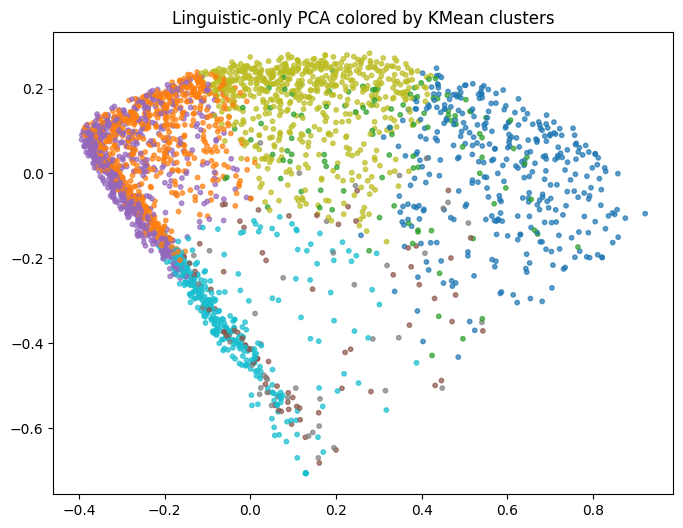

In [132]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
Z_l = PCA(n_components=2, random_state=42).fit_transform(X_ling)
plt.figure(figsize=(8,6))
plt.scatter(Z_l[:,0], Z_l[:,1], c=ling_df["kmeans_ling"], s=10, cmap="tab10", alpha=0.7)
plt.title("Linguistic-only PCA colored by KMean clusters")
plt.show()

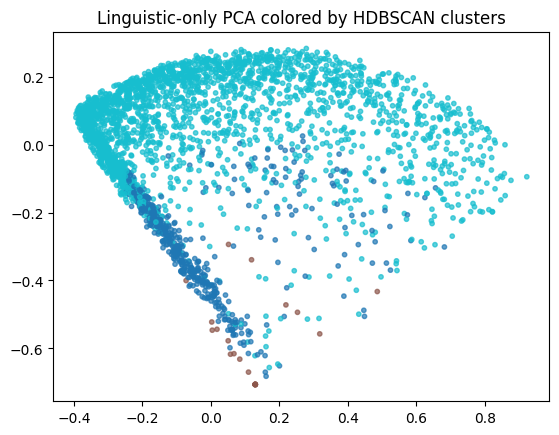

In [135]:
labels = ling_df["hdb_ling"]
colors = np.where(labels == -1, -1, labels)

plt.scatter(
    Z_l[:,0],
    Z_l[:,1],
    c=colors,
    s=10,
    cmap="tab10",
    alpha=0.7
)

plt.title("Linguistic-only PCA colored by HDBSCAN clusters")
plt.show()


In [26]:
df_time = df_new.dropna(subset=["author", "timestamp"]).copy()
df_time = df_time.dropna(subset=["timestamp"])

# basic bins
df_time["month"] = df_time["timestamp"].dt.month          # 1..12
df_time["dow"] = df_time["timestamp"].dt.dayofweek        # 0..6
df_time["date"] = df_time["timestamp"].dt.date            # day resolution

# month histogram (proportions)
month_counts = (
    df_time.groupby(["author", "month"]).size()
    .unstack(fill_value=0)
    .reindex(columns=range(1, 13), fill_value=0)
)
month_props = month_counts.div(month_counts.sum(axis=1), axis=0)
month_props.columns = [f"temp_month_{m:02d}" for m in month_props.columns]

# day-of-week histogram (proportions)
dow_counts = (
    df_time.groupby(["author", "dow"]).size()
    .unstack(fill_value=0)
    .reindex(columns=range(0, 7), fill_value=0)
)
dow_props = dow_counts.div(dow_counts.sum(axis=1), axis=0)
dow_props.columns = [f"temp_dow_{d}" for d in dow_props.columns]

# span + activity stats
agg = df_time.groupby("author").agg(
    n_posts=("timestamp", "size"),
    first_ts=("timestamp", "min"),
    last_ts=("timestamp", "max"),
    active_days=("date", "nunique"),
)
agg["span_days"] = (agg["last_ts"] - agg["first_ts"]).dt.days
agg["posts_per_active_day"] = agg["n_posts"] / agg["active_days"].clip(lower=1)

temp_df = pd.concat([month_props, dow_props, agg[["n_posts","active_days","span_days","posts_per_active_day"]]], axis=1).reset_index()
temp_df.head()


,author,temp_month_01,temp_month_02,temp_month_03,temp_month_04,temp_month_05,temp_month_06,temp_month_07,temp_month_08,temp_month_09,...,temp_dow_1,temp_dow_2,temp_dow_3,temp_dow_4,temp_dow_5,temp_dow_6,n_posts,active_days,span_days,posts_per_active_day
0,22,0.0,0.00000,0.0,0.00000,0.000000,0.615385,0.307692,0.000000,0.076923,...,0.230769,0.153846,0.153846,0.153846,0.076923,0.153846,13,10,77,1.300000
1,23,0.0,0.00000,0.0,0.00000,0.007353,0.041667,0.051471,0.161765,0.294118,...,0.210784,0.250000,0.188725,0.100490,0.019608,0.007353,408,67,144,6.089552
2,24,0.0,0.00000,0.0,0.00000,0.000000,0.253333,0.053333,0.226667,0.466667,...,0.173333,0.293333,0.266667,0.146667,0.053333,0.013333,75,34,87,2.205882
3,26,0.0,0.00000,0.8,0.20000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.200000,0.800000,0.000000,0.000000,0.000000,0.000000,5,2,5,2.500000
4,27,0.0,0.00123,0.0,0.00615,0.044280,0.050431,0.277983,0.432964,0.179582,...,0.195572,0.162362,0.118081,0.146371,0.115621,0.150062,813,107,241,7.598131


In [32]:
temp_cols = [c for c in temp_df.columns if c.startswith("temp_")]
X_temp = StandardScaler().fit_transform(temp_df[temp_cols].to_numpy(dtype=np.float32))

k = 8
km_t = KMeans(n_clusters=k, random_state=42, n_init="auto")
temp_df["kmeans_temp"] = km_t.fit_predict(X_temp)

In [37]:
temp_df["hdb_temp"] = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5).fit_predict(X_temp)

### Temporal Rhythm Clustering

Temporal rhythm clustering focuses on when users post, independent of posting volume. We use normalized month-of-year and day-of-week histograms (temp_*) to capture seasonal and weekly posting patterns. Density-based clustering is performed using HDBSCAN with min_cluster_size = 10 and min_samples = 5, allowing detection of tightly synchronized posting schedules while conservatively labeling the majority of users as noise, indicating a largely continuous temporal activity space.

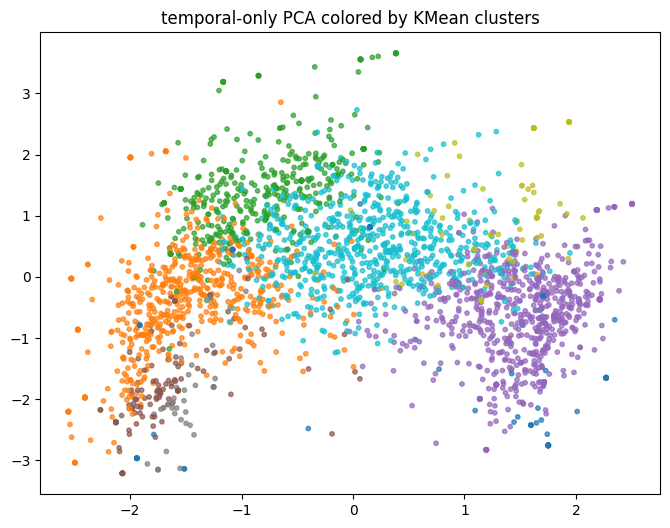

In [34]:
Z_t = PCA(n_components=2, random_state=42).fit_transform(X_temp)
plt.figure(figsize=(8,6))
plt.scatter(Z_t[:,0], Z_t[:,1], c=temp_df["kmeans_temp"], s=10, cmap="tab10", alpha=0.7)
plt.title("temporal-only PCA colored by KMean clusters")
plt.show()

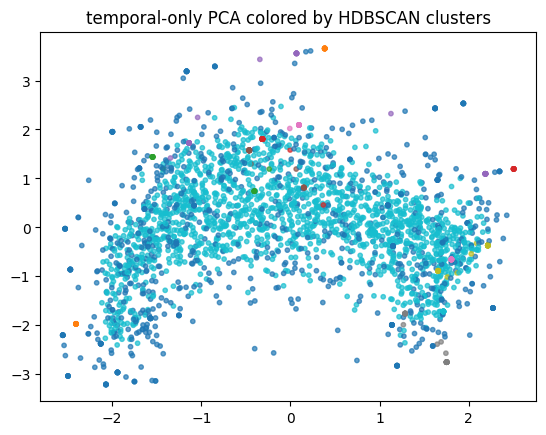

In [38]:
labels = temp_df["hdb_temp"]
colors = np.where(labels == -1, -1, labels)

plt.scatter(
    Z_t[:,0],
    Z_t[:,1],
    c=colors,
    s=10,
    cmap="tab10",
    alpha=0.7
)

plt.title("temporal-only PCA colored by HDBSCAN clusters")
plt.show()

In [39]:
np.unique(temp_df["hdb_temp"], return_counts=True)


(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18]),
 array([ 893,   13,   10,   10,   12,   10,   10,   21,   13,   23,   19,
          14,   16,   12,   11,   18,   16,   25,   17, 1601]))

In [44]:
activity_cols = ["n_posts","active_days","span_days","posts_per_active_day"]
X_activity = StandardScaler().fit_transform(temp_df[temp_activity_cols].to_numpy(dtype=np.float32))

k = 8
km_t = KMeans(n_clusters=k, random_state=42, n_init="auto")
temp_df["kmeans_activity"] = km_t.fit_predict(X_activity)

In [48]:
temp_df["hdb_activity"] = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3).fit_predict(X_activity)

### Activity Intensity Clustering
Activity clustering captures how much and how long users post, using aggregate statistics including total post count, number of active days, activity span, and posts per active day. HDBSCAN is applied with min_cluster_size = 5 and min_samples = 3, identifying small groups of highly active or bursty users while avoiding forced partitioning of the broader user population. This separation highlights differences in engagement intensity rather than posting schedule or linguistic style.

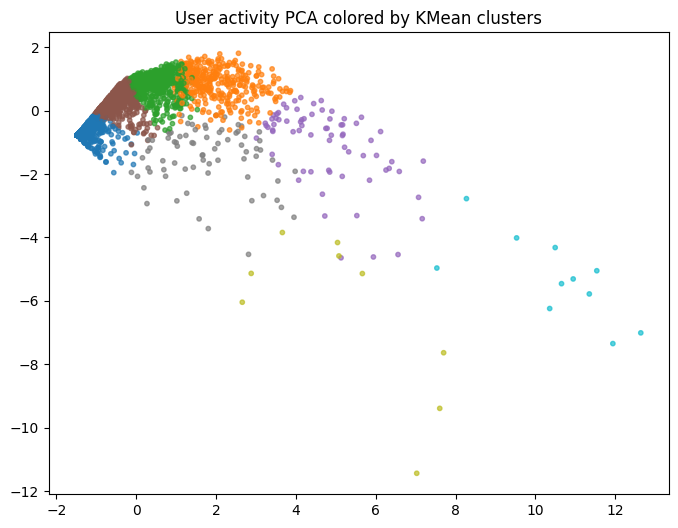

In [46]:
Z_a = PCA(n_components=2, random_state=42).fit_transform(X_temp_activity)
plt.figure(figsize=(8,6))
plt.scatter(Z_a[:,0], Z_a[:,1], c=temp_df["kmeans_activity"], s=10, cmap="tab10", alpha=0.7)
plt.title("User activity PCA colored by KMean clusters")
plt.show()

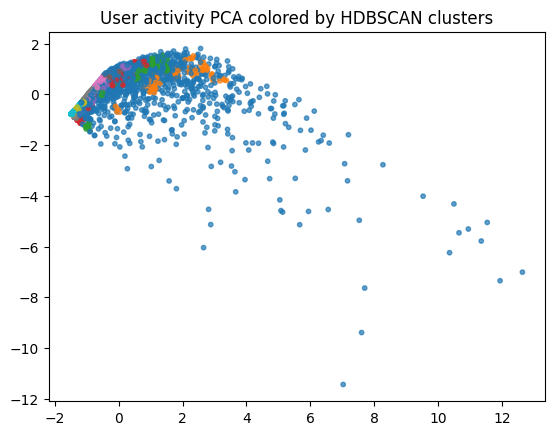

In [49]:
labels = temp_df["hdb_activity"]
colors = np.where(labels == -1, -1, labels)

plt.scatter(
    Z_a[:,0],
    Z_a[:,1],
    c=colors,
    s=10,
    cmap="tab10",
    alpha=0.7
)

plt.title("User activity PCA colored by HDBSCAN clusters")
plt.show()

In [136]:
path_ = "/Users/sargun/Desktop/truth social/truth_cleand.csv"
df_clean = pd.read_csv(path_)

In [137]:
df_clean.head()

,Unnamed: 0.1,Unnamed: 0,id,timestamp,author,like_count,retruth_count,reply_count,text,hate_pred,...,sentiment_id,sentiment_conf,sentiment,statement_flag,statement_probability,TRUTH_CLASS_x,NO_STMT,TRUE,FALSE,clusters
0,0,0,703265,13,2247,0,0,0,q+ be ready anons - public awakening coming - ...,0,...,1,0.851504,neutral,0,0.010807,NaN,NaN,NaN,NaN,"[5, 5, 5, 5, 5, 5]"
1,1,1,807614,6,20054,0,0,0,enough is enough! retruth,0,...,1,0.489587,neutral,0,0.029001,NaN,NaN,NaN,NaN,[5]
2,2,2,807621,6,20054,0,0,0,joe biden wants this video removed from the in...,0,...,0,0.817848,negative,1,0.519844,0.0,0.943432,0.020946,0.035622,[5]
3,3,3,807622,6,20054,0,0,0,<emoji: dart><emoji: 100><emoji: us>,0,...,1,0.861522,neutral,0,0.011909,NaN,NaN,NaN,NaN,[5]
4,4,4,807625,5,20054,0,0,0,#truth #soros #ukraine,0,...,1,0.685714,neutral,0,0.035824,NaN,NaN,NaN,NaN,[5]


In [138]:
styl_map = ling_df[["author", "kmeans_ling"]].rename(
    columns={"kmeans_ling": "style_cluster"}
)

In [139]:
df_clean = df_clean.merge(styl_map, on="author", how="left")

In [141]:
df_clean["style_cluster"].value_counts(dropna=False)

style_cluster
6.0    176401
1.0    139170
3.0    127708
0.0    111984
2.0     33425
7.0      3755
5.0      3701
4.0       613
NaN         1
Name: count, dtype: int64

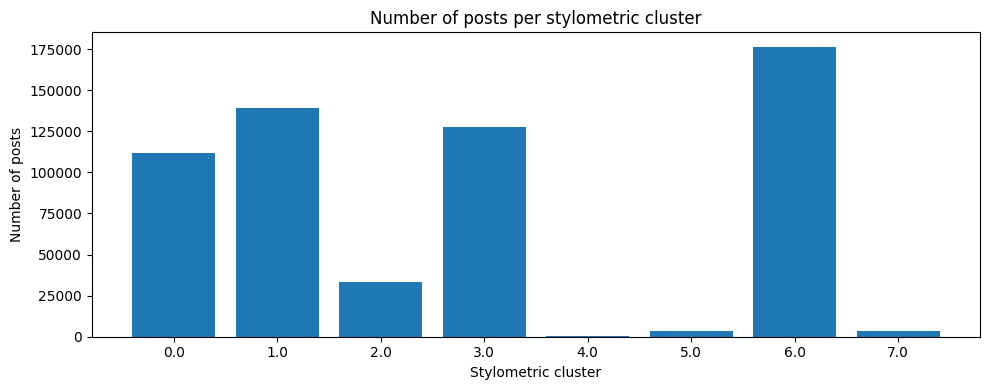

In [142]:
counts = (
    df_clean["style_cluster"]
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(10,4))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Stylometric cluster")
plt.ylabel("Number of posts")
plt.title("Number of posts per stylometric cluster")
plt.tight_layout()
plt.show()


In [148]:
temp_map = temp_df[["author", "kmeans_activity", "kmeans_temp"]].rename(
    columns={"kmeans_activity": "activity_cluster","kmeans_temp": "temporal_rhythm_cluster"}
)
df_clean = df_clean.merge(temp_map, on="author", how="left")


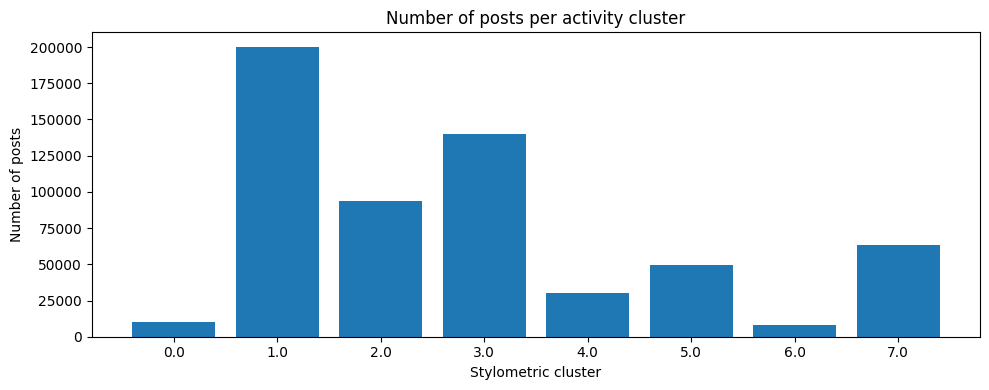

In [149]:
counts = (
    df_clean["activity_cluster"]
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(10,4))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Stylometric cluster")
plt.ylabel("Number of posts")
plt.title("Number of posts per activity cluster")
plt.tight_layout()
plt.show()

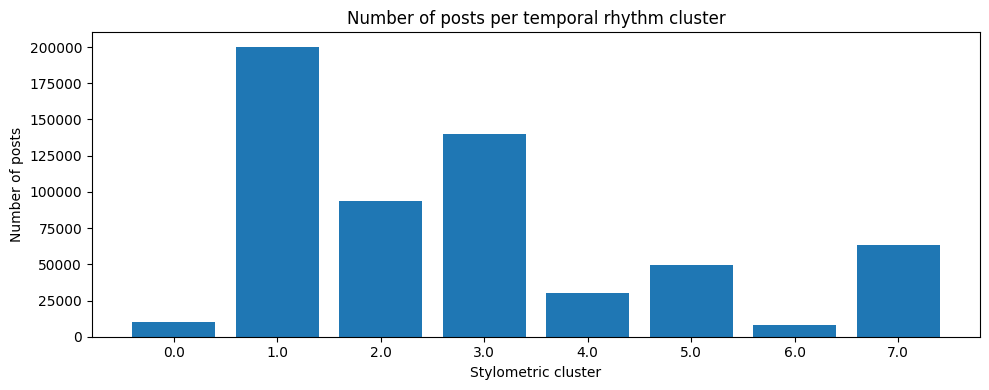

In [150]:
counts = (
    df_clean["activity_cluster"]
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(10,4))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Stylometric cluster")
plt.ylabel("Number of posts")
plt.title("Number of posts per temporal rhythm cluster")
plt.tight_layout()
plt.show()

In [151]:
out_path = "truthsocial_posts_analysis.csv"
df_clean.to_csv(out_path, index=False)
print("Saved:", out_path)

Saved: truthsocial_posts_analysis.csv
